## Data Mining Final
- optimized information gain
- arbitrary tree depth
- removing less-helpful features
- sample $\frac{n}{3}$ instead of $\sqrt{n}$

> Information Gain

> Forest Building

> Analysis

> Feature Review

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
data = pd.read_csv("mutationc.csv",index_col=0)
np.random.seed(63)

## Information Gain
* Note on numpy arrays vs pandas dataframes:
    * From activity 8 I've found my common bottleneck to be the information gain function.
    * Convert dataframe to numpy array first and vectorize operations, it is over 100x faster.
* [Source](https://penandpants.com/2014/09/05/performance-of-pandas-series-vs-numpy-arrays/)

In [96]:
idx = data.index.astype(str)
C_mask = data.index.to_series().str.match(r"^C\d+$")
NC_mask = data.index.to_series().str.match(r"^NC\d+$")

def entropy(P_C_t,P_NC_t):
    ans = 0.0
    if P_C_t > 0:
        ans -= P_C_t * math.log2(P_C_t)
    if P_NC_t > 0:
        ans -= P_NC_t * math.log2(P_NC_t)
    return ans

def information_gain(group:pd.DataFrame):
    n = group.shape[0]
    is_C = C_mask.loc[group.index].to_numpy()
    is_NC = NC_mask.loc[group.index].to_numpy()
    P_C_t = is_C.mean()
    P_NC_t = is_NC.mean()
    H_t = entropy(P_C_t, P_NC_t)
    data_np = group.to_numpy()
    cols = group.columns
    gains = np.zeros(data_np.shape[1])
    for i in range(data_np.shape[1]):
        col = data_np[:,i]
        left_mask = (col == 1)
        right_mask = (col == 0)
        n_tL = int(left_mask.sum())
        n_tR = n - n_tL
        n_tL_C  = int((left_mask  & is_C).sum())
        n_tL_NC = int((left_mask  & is_NC).sum())
        n_tR_C  = int((right_mask & is_C).sum())
        n_tR_NC = int((right_mask & is_NC).sum())
        P_L = n_tL / n
        P_R = n_tR / n
        P_C_tL  = n_tL_C  / n_tL if n_tL != 0 else 0
        P_NC_tL = n_tL_NC / n_tL if n_tL != 0 else 0
        P_C_tR  = n_tR_C  / n_tR if n_tR != 0 else 0
        P_NC_tR = n_tR_NC / n_tR if n_tR != 0 else 0
        H_st = P_L * entropy(P_C_tL, P_NC_tL) + P_R * entropy(P_C_tR, P_NC_tR)
        gains[i] = H_t - H_st

    return pd.DataFrame({"gain(s)": gains}, index=cols)

## Tree Creation

In [97]:
class Node:
    def __init__(self, feature=None, left=None, right=None, prediction=None):
        self.feature = feature
        self.left = left
        self.right = right
        self.prediction = prediction

    def is_leaf(self):
        return self.prediction is not None

    def __repr__(self):
        if self.is_leaf():
            return f"{self.prediction})"
        return f"{self.feature}"

class Tree:
    def __init__(self, root=None, oob=None):
        self.root = root
        self.oob = oob

    def classify(self, sample):
        node = self.root
        # tree traversal
        while not node.is_leaf():
            if sample[node.feature] == 1:
                node = node.left
            else:
                node = node.right
        return node.prediction # return leaf prediction
    
    def __repr__(self):
        return f"{self.root},{len(self.oob)}"
            
def leaf_majority(leaf:pd.DataFrame):
    leaf_idx = leaf.index.to_series().replace(r'^C\d+$','1',regex=True).replace(r'^NC\d+$','0',regex=True).astype(int)
    if leaf_idx.mean() > 0.5:
        return 1 # majority cancer
    else:
        return 0 # majority noncancer
    
def create_node(group:pd.DataFrame,depth:int,max_depth:int,k:int):
    # break case: if reached the maximum depth or length is 0 return the prediction for that leaf
    if depth == max_depth or len(group) == 0:
        return Node(prediction=leaf_majority(group))
    
    # remove less helpful features
    gain = information_gain(group)
    low_gain = gain.sort_values(by="gain(s)").head(int(data.shape[0] * 0.2)) # remove the bottom 20%
    gain.drop(low_gain.index)

    # break case: if there is no available feaures vote majority of current group
    if len(gain) == 0:
        return Node(prediction=leaf_majority(group))
    
    # select (k=n/3) features and split into left and right nodes
    features = gain.sample(n=min(k,len(gain)))["gain(s)"]
    root = features.idxmax()
    left_data = group[group[root] == 1]
    right_data = group[group[root] == 0]

    # if one side is completely empty return the leaf node majority of the current group
    if len(left_data) == 0 or len(right_data) == 0:
        return Node(prediction=leaf_majority(group))
    
    # recurse
    left_child = create_node(left_data,depth+1,max_depth,k)
    right_child = create_node(right_data,depth+1,max_depth,k)

    # return tree
    return Node(feature=root,left=left_child,right=right_child)

def create_tree(group:pd.DataFrame,max_depth:int):
    """
        Create a tree using bootstrap dataset, report back tree and out of bag dataset
    """
    bootstrap = group.sample(n=len(group),replace=True)
    oob = group.loc[~group.index.isin(bootstrap.index)]
    k = math.ceil(data.shape[1] / 3)
    root = create_node(bootstrap,0,max_depth,k)
    return Tree(root,oob)

In [98]:
def truncate_feature(name: str, maxlen: int = 40) -> str:
    """Truncate at the first ':' and also limit length for very long names."""
    if name is None:
        return ""
    short = name.split(":", 1)[0]
    if len(short) > maxlen:
        return short[:maxlen-1] + "…"
    return short

def node_label(node, maxlen=40):
    return str(node.prediction) if node.is_leaf() else truncate_feature(node.feature, maxlen)

def _make_empty_line(width):
    return " " * width

def draw_boxed_label(label):
    """Return three strings that draw a rounded box around the label:
       ╭────╮
       │lbl │
       ╰────╯
    """
    inner = label
    inner_w = len(inner)
    top = "╭" + "─" * inner_w + "╮"
    mid = "│" + inner + "│"
    bot = "╰" + "─" * inner_w + "╯"
    return [top, mid, bot], inner_w + 2  # width includes the two corner chars

def combine_side_by_side(left, right, gap):
    """Given two lists of lines, pad them to same height and return combined lines with gap spaces."""
    lh = len(left); rh = len(right)
    h = max(lh, rh)
    left_pad = left + [" " * len(left[0])] * (h - lh)
    right_pad = right + [" " * len(right[0])] * (h - rh)
    spacer = " " * gap
    return [left_pad[i] + spacer + right_pad[i] for i in range(h)]

# disclaimer: the tree printing section of this program is made using generative AI
def draw_tree(node, gap=4, label_maxlen=40):
    """
    Returns lines (list[str]) that represent the tree.
    gap: horizontal gap between left and right subtrees (in characters).
    """
    # Base (leaf)
    if node.is_leaf():
        lbl = node_label(node, label_maxlen)
        return [lbl], len(lbl), 1, len(lbl)//2  # lines, width, height, mid_index

    # Draw left and right subtrees recursively
    left_lines, left_w, left_h, left_mid = draw_tree(node.left, gap, label_maxlen)
    right_lines, right_w, right_h, right_mid = draw_tree(node.right, gap, label_maxlen)

    # Combine children horizontally
    children_w = left_w + gap + right_w
    children_lines = combine_side_by_side(left_lines, right_lines, gap)

    # Create boxed label for current node
    lbl = node_label(node, label_maxlen)
    box_lines, box_w = draw_boxed_label(lbl)

    # Determine horizontal positions (absolute indices) of child centers
    left_center = left_mid
    right_center = left_w + gap + right_mid

    # We will center the box above the mid-point between left_center and right_center
    children_center = (left_center + right_center) // 2
    box_start = children_center - (box_w // 2)
    if box_start < 0:
        # if box would start before 0, shift everything right
        shift = -box_start
        children_w += shift
        left_center += shift
        right_center += shift
        box_start = 0
        children_lines = [" " * shift + ln for ln in children_lines]

    # Ensure the entire canvas is wide enough to include box at its position
    total_w = max(children_w, box_start + box_w)
    # pad children lines to total_w
    children_lines = [ln + " " * (total_w - len(ln)) for ln in children_lines]

    # Build canvas lines for top box (3 lines)
    top_canvas = [" " * total_w for _ in range(3)]

    # Overlay box_lines into top_canvas at box_start
    for i in range(3):
        line = list(top_canvas[i])
        for j, ch in enumerate(box_lines[i]):
            line[box_start + j] = ch
        top_canvas[i] = "".join(line)

    connector_line = list(" " * total_w)
    # compute box bottom center:
    box_center = box_start + box_w // 2
    # horizontal line from left_center to right_center
    a = min(left_center, right_center)
    b = max(left_center, right_center)
    for x in range(a, b + 1):
        connector_line[x] = "─"
    # put junction markers
    connector_line[box_center] = "┴"  # where box connects downwards
    connector_line[left_center] = "┬"
    connector_line[right_center] = "┬"

    connector_line = "".join(connector_line)

    bot_line = list(top_canvas[2])

    # Compose final lines:
    lines = []
    lines.extend(top_canvas)         # box top/mid/bottom
    lines.append(connector_line)     # ────┬───┴───┬────
    lines.extend(children_lines)     # children drawn below

    # Trim trailing spaces for cleaner look (but keep at least 1 space width)
    lines = [ln.rstrip() for ln in lines]
    width = max(len(ln) for ln in lines)
    # re-pad so every line has same width
    lines = [ln + " " * (width - len(ln)) for ln in lines]

    # compute mid for this subtree: where the box center is in absolute coordinates
    mid = box_center

    return lines, width, len(lines), mid

def print_tree(tree, gap=4, label_maxlen=40):
    lines, width, height, mid = draw_tree(tree.root, gap, label_maxlen)
    # Print each line; notebooks will show monospaced output if using default code cell output.
    for ln in lines:
        print(ln.rstrip())


## Forest Classification

In [99]:
print("Forest Generation")
NUM_TREES = 25
forest = []
oob_sum = 0.0
for trial in range(1,NUM_TREES+1):
    gen_tree = create_tree(data,6)
    print(f"--- tree {trial} -------------------------")
    print_tree(gen_tree)
    print(f"------------------------------------\n")
    oob_sum += len(gen_tree.oob)
    forest.append(gen_tree)
print(f"OOB Average: {oob_sum / NUM_TREES}")

def forest_classifier(idx,sample,forest):
    votes = []
    for t in forest:
        votes.append(t.classify(sample))
    votes_for_C = sum(votes)
    votes_for_NC = len(votes) - votes_for_C
    if votes_for_C > votes_for_NC:
        label = "C"
        value = 1
    else:
        label = "NC"
        value = 0
    return pd.Series({"idx":idx,"label":label, "value":value,
            "C_votes":votes_for_C,"NC_Votes":votes_for_NC})

Forest Generation
--- tree 1 -------------------------
                ╭─────────────╮
                │BRAF_GRCh37_7│
                ╰─────────────╯
         ┬─────────────┴─────────────┬
╭────────────────╮           ╭───────────────╮
│ZNF765_GRCh37_19│           │RCVRN_GRCh37_17│
╰────────────────╯           ╰───────────────╯
   ┬─────┴──────┬              ┬─────┴──────┬
   0    ╭───────────────╮      1    ╭──────────────╮
        │WDR66_GRCh37_12│           │DIS3_GRCh37_13│
        ╰───────────────╯           ╰──────────────╯
              ┬─┴──┬                  ┬─────┴─────┬
              0    1                  1    ╭────────────╮
                                           │APC_GRCh37_5│
                                           ╰────────────╯
                                           ┬──────┴──────┬
                                           1    ╭────────────────╮
                                                │ATP10A_GRCh37_15│
                                             

## Results

In [100]:
def compute_metrics(actual:pd.Series,predicted:pd.Series,print_cm=None):
    """
        Compute confusion matrix given actual and predicted sets
    """
    TP = ((actual == 1) & (predicted == 1)).sum(axis=0)
    FP = ((actual == 0) & (predicted == 1)).sum(axis=0)
    FN = ((actual == 1) & (predicted == 0)).sum(axis=0)
    TN = ((actual == 0) & (predicted == 0)).sum(axis=0)
    if print_cm is not None:
        cm = np.array([[TP, FN],
                   [FP, TN]])
        plt.figure(figsize=(5,4))
        plt.imshow(cm)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.xticks([0,1], ["Cancer (1)", "Non-Cancer (0)"])
        plt.yticks([0,1], ["Cancer (1)", "Non-Cancer (0)"])
        for i in range(2):
            for j in range(2):
                plt.text(j, i, cm[i, j], ha='center', va='center')

    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    Sensitivity = TP / (TP + FN)
    Specificity = TN / (TN + FP)
    Precision = TP / (TP + FP)
    Miss_rate = FN / (TP + FN)
    False_discovery_rate = FP / (TP + FP)
    False_omission_rate = FN / (FN + TN)
    metrics = pd.DataFrame({"Accuracy":Accuracy,"Sensitivity":Sensitivity,
                            "Specificity":Specificity,"Precision":Precision,
                            "Miss Rate":Miss_rate,"False Discovery Rate":False_discovery_rate,
                            "False Omission Rate":False_omission_rate},index=[0])
    return metrics

In [101]:
# average metrics for every tree out of bag dataset
results = []
for i in range(NUM_TREES):
    samples = forest[i].oob.index.to_list()
    oob = forest[i].oob
    oob_classification = []
    for sample in samples:
        result = forest_classifier(sample,oob.loc[sample],forest)
        oob_classification.append(result)
    predicted = pd.Series([s.value for s in oob_classification],index=samples)
    actual = oob.index.to_series().replace(r'^C\d+$','1',regex=True).replace(r'^NC\d+$','0',regex=True).astype(int)
    results.append(compute_metrics(actual,predicted))
sum(results) / NUM_TREES

,Accuracy,Sensitivity,Specificity,Precision,Miss Rate,False Discovery Rate,False Omission Rate
0,0.741536,0.542804,0.943387,0.905695,0.457196,0.094305,0.329667


In [102]:
def compute_feature_importance(forest,group):
    """
        Accumulate the amount of gain each feature in each tree the forest contributes to the forest
    """
    importance = pd.Series(0.0,index=group.columns)
    def acc_gains(node,data):
        if node.is_leaf():
            return
        feature = node.feature
        if feature is not None:
            gain = information_gain(group)
            importance[feature] += gain.loc[feature,"gain(s)"]
            left_data = group[group[feature] == 1]
            right_data = group[group[feature] == 0]
            acc_gains(node.left,left_data)
            acc_gains(node.right,right_data)
    for tree in forest:
        acc_gains(tree.root,group)
    return importance.sort_values(ascending=False)

feature_importance = compute_feature_importance(forest,data)

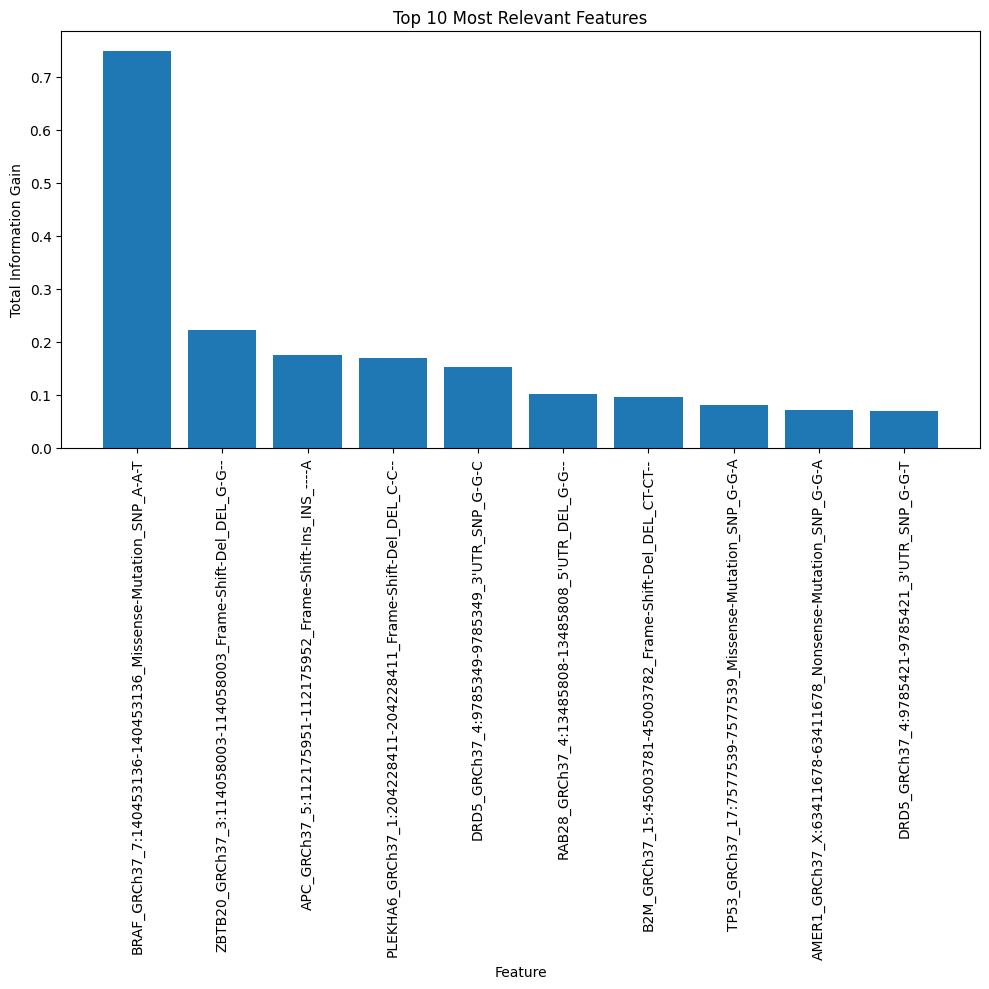

In [103]:
plt.figure(figsize=(10,10))
plt.bar(feature_importance.index[:10], feature_importance.values[:10])
plt.xticks(rotation=90)
plt.title("Top 10 Most Relevant Features")
plt.ylabel("Total Information Gain")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

## Review

The most prevelant feature for the entire semester BRAF_GRCh37_7. The presence of mutation BRAF V600E is connected to melanoma, thyroid and lung cancers.
[Source](https://www.oncokb.org/hgvsg/7:g.140453136A%3ET?refGenome=GRCh37). That specific mutation is defined as a Oncogene activation, which tampers with the process of cell death, causing cells to survice and reproduce instead of die when they are supposed to. [Source](https://en.wikipedia.org/wiki/Oncogene)

APC_GRCh37_5 is a well known protein Adenomatous Polyposis Coli, which is classified as a 'tumor suppressor gene' [Source](https://en.wikipedia.org/wiki/Adenomatous_polyposis_coli). I presume a mutation in this function would cause the body to be less effective at battling tumors.

Selecting a less prevelant but still top 10 feature from my graph on seed 60, QKI or "Quaking", is another tumor suppressing gene. It has links to gastric cancer as published in a paper by The State Key Laboratory of Cancer Biology in Xi'an, China [Source](https://pubmed.ncbi.nlm.nih.gov/22569043/)